In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
df = pd.read_csv("sales.csv")
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [3]:
df = df[df.sales.notna()].reset_index(drop=True)
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [5]:
from datetime import datetime, date 

df['date'] = pd.to_datetime(df['date'])
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


<Axes: xlabel='date', ylabel='sales'>

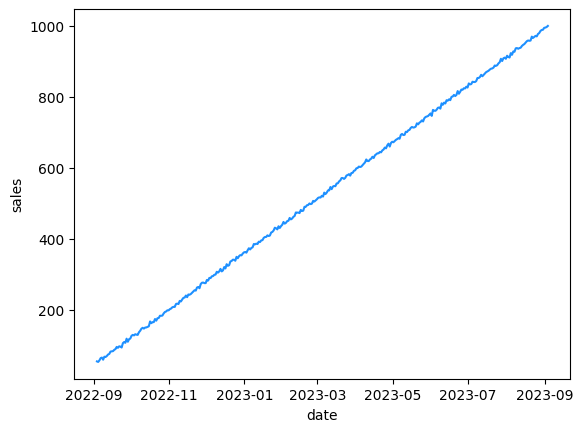

In [10]:
sns.lineplot(x = df['date'], y=df['sales'].fillna(method='ffill'), color='dodgerblue')

## Chronological Order and Equidistant Timestamps

The data should be in chronological order and the timestamps should be equidistant in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data.

But, first of all, lets see how to check if our dataset is correctly formated!

In [11]:
df = df.sort_values(by='date')

# Check time intervals
df['delta'] = df['date'] - df['date'].shift(1)

df[['date', 'delta']].head()

,date,delta
0,2022-09-03 17:10:08.079328,NaT
1,2022-09-04 17:10:08.079328,1 days
2,2022-09-05 17:10:08.079328,1 days
3,2022-09-06 17:10:08.079328,1 days
4,2022-09-07 17:10:08.079328,1 days


In [12]:
df['delta'].sum(), df['delta'].count()

(Timedelta('365 days 00:00:00'), 365)

As we can see, we have a full year of recorded sales

In [13]:
df = df.drop('delta', axis=1)
df.isna().sum()

date     0
sales    0
dtype: int64

WE HAVE NO MISSING VALUES, SO WE DON'T NEED TO TACKLE THIS ISSUE

## Resample the data for weeks or quarters

<Axes: xlabel='date', ylabel='sales'>

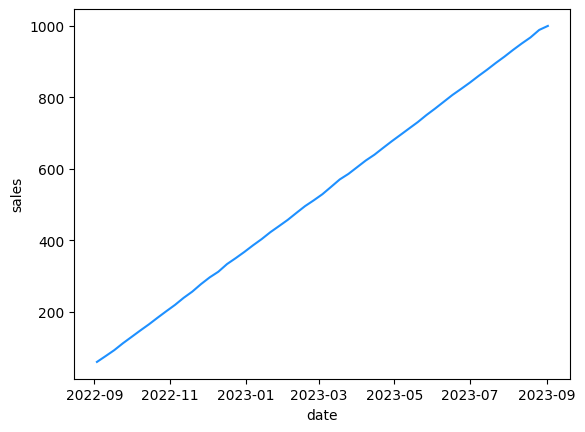

In [16]:
weekly_df = df.resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(x=weekly_df['date'], y=weekly_df['sales'], color='dodgerblue')

<Axes: xlabel='date', ylabel='sales'>

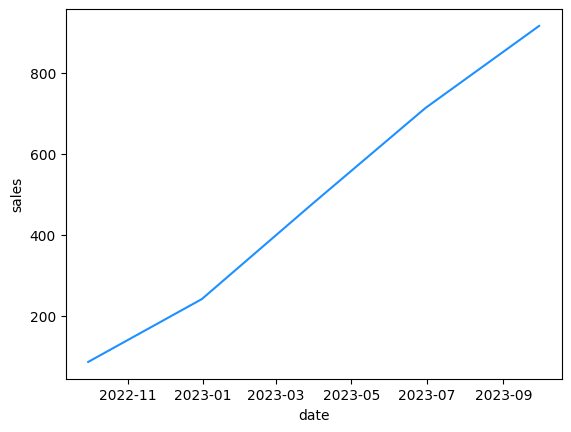

In [17]:
quarter_df = df.resample('Q', on='date').mean().reset_index(drop=False)
sns.lineplot(x=quarter_df['date'], y=quarter_df['sales'], color='dodgerblue')

Downsample to quarter level might yield interesting results

## Stationary check

<Axes: xlabel='date', ylabel='sales'>

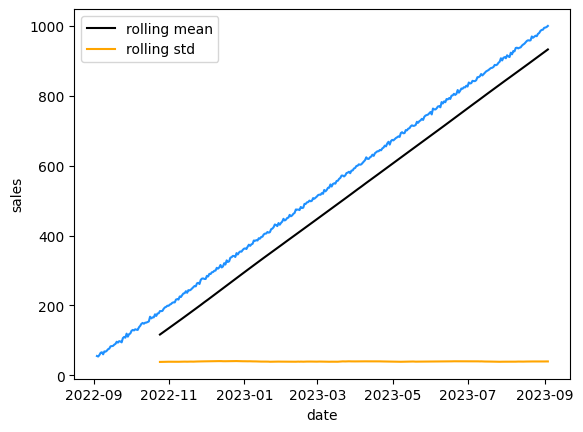

In [19]:
rolling_window = 52

sns.lineplot(x=df['date'], y=df['sales'], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['sales'].rolling(rolling_window).mean(), color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['sales'].rolling(rolling_window).std(), color='orange', label='rolling std')

In [21]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['sales'].values)
result

(0.5454141937063742,
 0.9861899815311063,
 13,
 352,
 {'1%': -3.4490648539347544,
  '5%': -2.8697861692116478,
  '10%': -2.5711631253228306},
 1764.0625918370981)

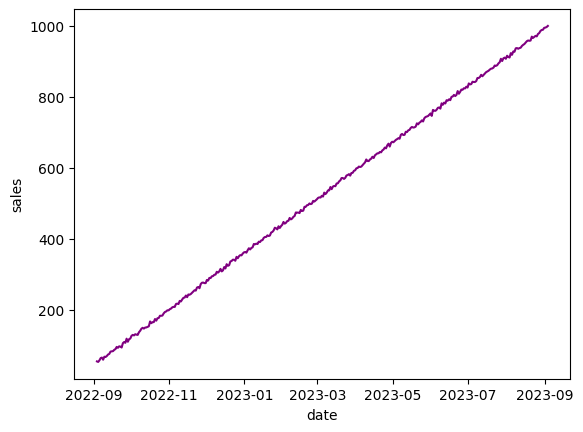

In [22]:
def visualize_adfuller_results(series):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, color=linecolor)


visualize_adfuller_results(df['sales'])

## Serie's decomposition and trend / seasonality / residual

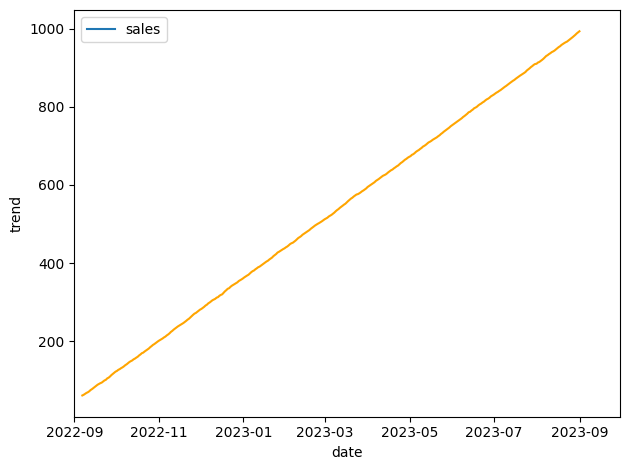

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

trend = seasonal_decompose(df.set_index('date')).trend

sns.lineplot(trend, color='orange')

ax = plt.gca()

ax.set_xlim([date(2022, 9, 1), date(2023, 9, 30)])

plt.tight_layout()

plt.show()

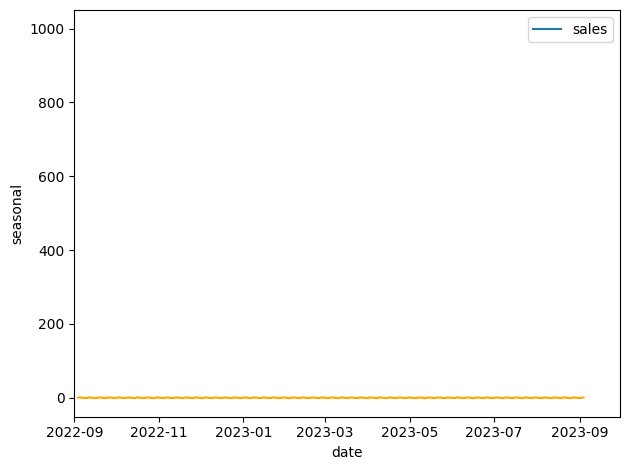

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

season = seasonal_decompose(df.set_index('date')).seasonal

sns.lineplot(season, color='orange')

ax = plt.gca()

ax.set_xlim([date(2022, 9, 1), date(2023, 9, 30)])

plt.tight_layout()

plt.show()

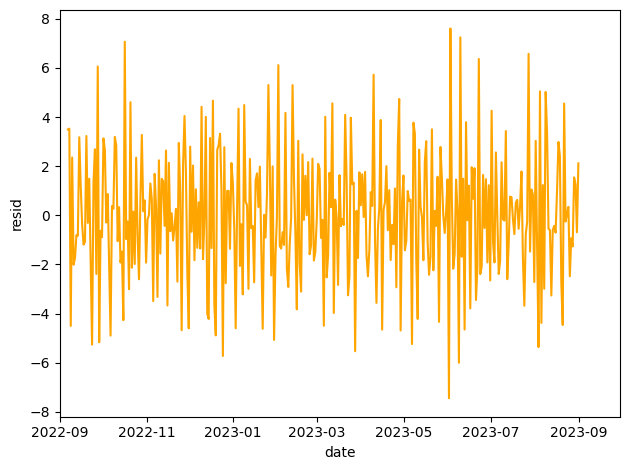

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

residual = seasonal_decompose(df.set_index('date')).resid

sns.lineplot(residual, color='orange')

ax = plt.gca()

ax.set_xlim([date(2022, 9, 1), date(2023, 9, 30)])

plt.tight_layout()

plt.show()

## Autocorrelation analysis

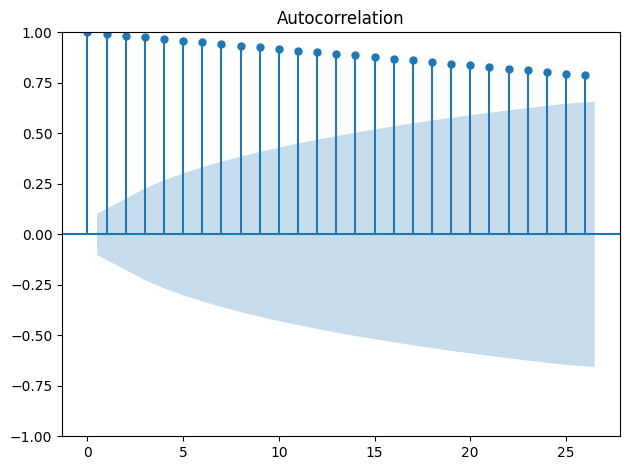

In [30]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df.set_index('date'))

plt.tight_layout()

plt.show()

## ARIMA training

In [32]:
from pmdarima import auto_arima

model = auto_arima(df.set_index('date'), seasonal = False, trace = True, m = 52) # m is 52 because there are 52 weeks in a year

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1843.274, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2096.542, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1970.972, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1839.586, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2209.657, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1839.552, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1841.532, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1843.586, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1839.607, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1922.648, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.690 seconds


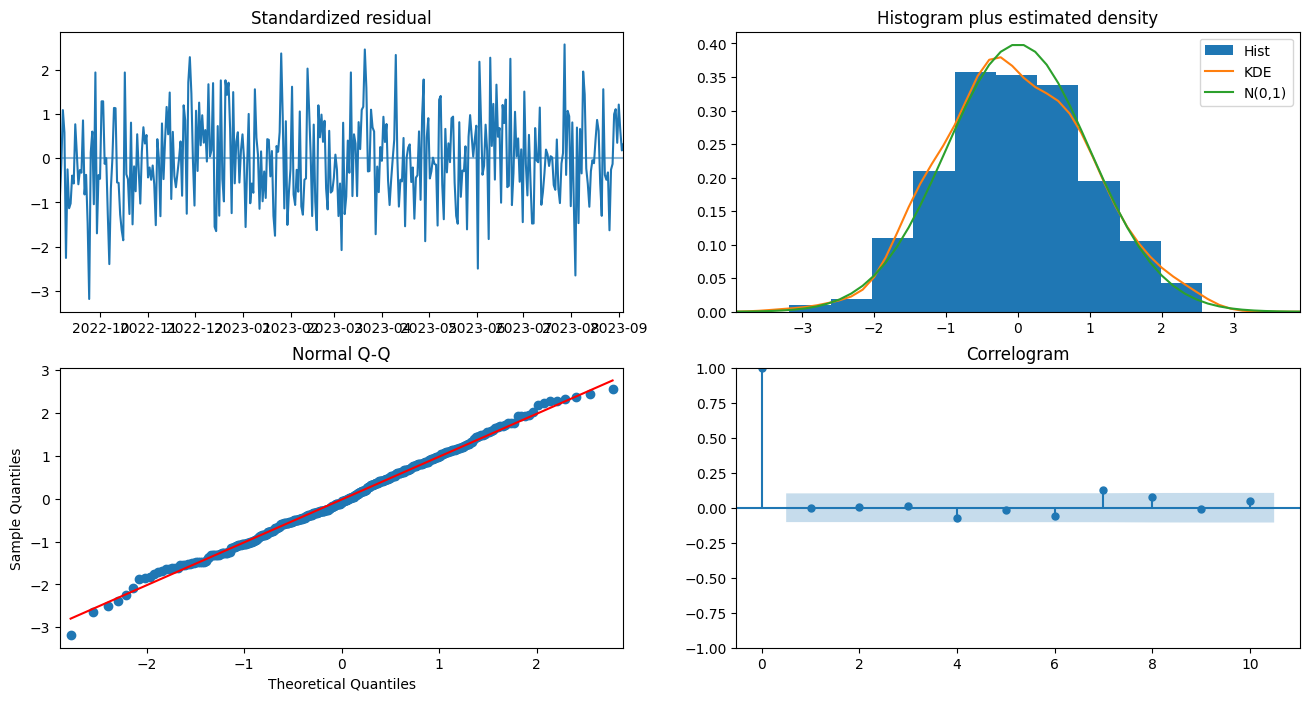

In [33]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

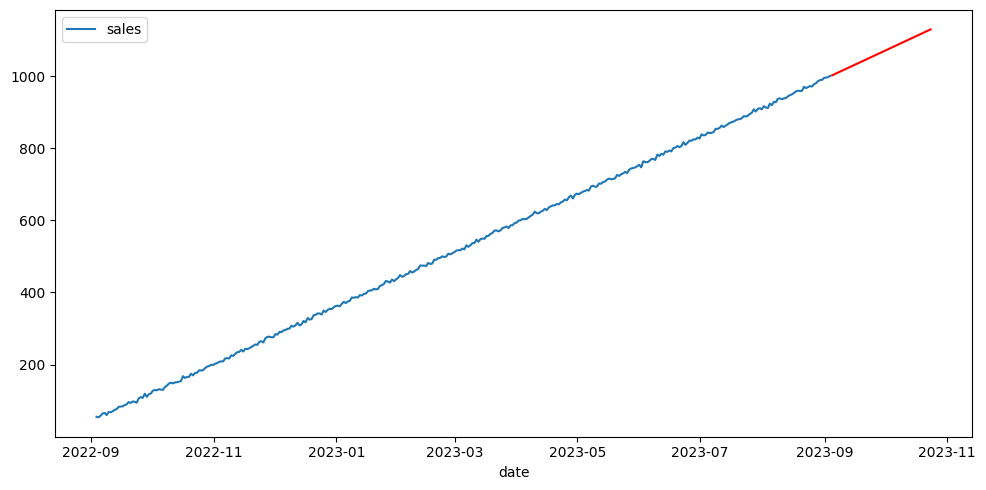

In [35]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df.set_index('date'))
sns.lineplot(data = model.predict(50), c = "red")

plt.tight_layout()

plt.show()

In [36]:
import pickle

with open('model/arima.pkl', 'wb') as pkl:
    pickle.dump(model, pkl)